## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer

from pathlib import Path
import warnings

------------

## Configs

In [5]:
warnings.filterwarnings('ignore')

raw_data_path = Path('../00_dados/raw/sample_teste_nlp.csv')

# Baixar as stopwords em português
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


------------

## Funções Auxiliares

In [8]:
def plot_histograma_porcentagem(df, column, title="Distribuição", color="skyblue"):
    """
    Plota um gráfico de barras mostrando a distribuição percentual de uma coluna categórica ou numérica em um DataFrame.
    
    Parâmetros:
        df (pd.DataFrame): O DataFrame contendo os dados.
        column (str): O nome da coluna categórica ou numérica a ser plotada.
        title (str): O título do gráfico. Default é "Distribuição".
        color (str): A cor das barras. Default é "skyblue".
        
    Retorna:
        None
    """
    # Checa se a coluna existe no DataFrame
    if column not in df.columns:
        raise ValueError(f"A coluna '{column}' não foi encontrada no DataFrame.")
    
    # Calcula a contagem e o percentual de cada categoria, mantendo a ordem correta para colunas numéricas
    category_counts = df[column].value_counts(normalize=True) * 100  # Em porcentagem

    # Detecta se a coluna é numérica e ordena os índices apropriadamente
    if pd.api.types.is_numeric_dtype(df[column]):
        category_counts = category_counts.sort_index()  # Ordena numericamente
    else:
        category_counts = category_counts.sort_values(ascending=False)  # Ordena por frequência se for categórico

    categories = category_counts.index
    percentages = category_counts.values

    # Configuração do estilo do gráfico
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Gráfico de barras
    ax = sns.barplot(x=categories, y=percentages, color=color, edgecolor="black")
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(column, fontsize=14)
    ax.set_ylabel("Percentual (%)", fontsize=14)
    
    # Adiciona o percentual sobre as barras
    for i, percentage in enumerate(percentages):
        ax.text(i, percentage + 1, f"{percentage:.1f}%", ha='center', va='bottom', fontsize=12, fontweight="bold")
    
    # Melhora layout do gráfico
    plt.ylim(0, max(percentages) * 1.15)  # Adiciona espaço acima das barras para as anotações
    plt.tight_layout()
    plt.show()


def classifica_texto(df):
    if 'html' in df.text:
        return 'html'
    elif 'rtf' in df.text:
        return 'rft'
    else:
        return 'texto simples'


def limpar_texto(texto):
    """
    Limpa um texto removendo formatações HTML e RTF, caracteres especiais, 
    quebras de linhas e sequências de escape, remove termos de fontes comuns ,
    padrões desnecessáriose convertendo para minúsculas para análise de NLP.
    
    Parâmetros:
    - texto (str): O texto a ser limpo.

    Retorna:
    - str: Texto limpo e processado.
    """    
    # Remove tags HTML
    texto = BeautifulSoup(texto, "html.parser").get_text()
    
    # Remove códigos específicos do RTF e padrões de formatação
    texto = re.sub(r'\\[a-z]+[0-9]*', '', texto)  # Remove tags RTF como \ansi, \fonttbl, etc.
    texto = re.sub(r'{\\.*?}', '', texto)         # Remove grupos RTF como {\rtf1...}
    texto = re.sub(r'[{}\[\]]', '', texto)        # Remove colchetes e chaves do RTF {, }, [, ]
    
    # Remove quebras de linha e sequências de escape como \r\n
    texto = re.sub(r'\r\n|\r|\n', ' ', texto)     # Substitui por espaço para manter a separação entre palavras
    
    # Remove nomes de fontes comuns, padrões desnecessários e termos como "default"
    fontes = r'\b(?:arial|wingdings|monospaced|courier|times new roman|verdana|' \
             r'calibri|microsoft sans serif|unicode ms|default)\b'
    texto = re.sub(fontes, '', texto, flags=re.IGNORECASE)
    
    # Remove outros caracteres especiais, mas mantém acentos e cedilha, e converte o texto para minúsculas
    texto = re.sub(r'[^a-zA-Z0-9\sáéíóúâêîôûãõçÁÉÍÓÚÂÊÎÔÛÃÕÇ]', '', texto)  
    texto = texto.lower().strip()
    
    return texto


def corrigir_codificacao(texto):
    # Dicionário com mapeamentos de códigos para caracteres equivalentes
    mapeamento = {
        'c3': 'ã',
        'c7': 'ç',
        'e7': 'ç',
        'e3': 'ã',
        'f3': 'ó',
        'c9': 'é',
        'e9': 'é',
        'e1': 'á',
        'c1': 'á',
        'e9': 'é',
        'e2': 'â',
        'c2': 'â',
        'f5': 'ô'    
    }
    
    # Aplicar cada substituição de acordo com o mapeamento
    for padrao, caractere in mapeamento.items():
        texto = re.sub(padrao, caractere, texto, flags=re.IGNORECASE)

    # Remove números isolados e espaços extras
    texto = re.sub(r'\b\d+\b', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    
    return texto


def remove_stopwords(text):
    
    # Tokenizar e remover stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    
    # Juntar tokens novamente em uma string
    return ' '.join(tokens)


def contar_palavras_por_tipo(df, tipo_texto, top_n=10):
    # Filtra os textos por tipo
    textos_filtrados = df[df['text_type'] == tipo_texto]['clean_text']
    
    # Usando CountVectorizer para contar palavras
    vectorizer = CountVectorizer(stop_words=list(stop_words))  # Adicione stop words para o português
    word_counts = vectorizer.fit_transform(textos_filtrados)
    
    # Obter as palavras e suas contagens
    contagens = word_counts.toarray().sum(axis=0)
    palavras = vectorizer.get_feature_names_out()
    
    # Criar um DataFrame com as palavras e contagens
    df_palavras = pd.DataFrame({'Palavra': palavras, 'Frequência': contagens})
    
    # Ordenar pelas palavras mais frequentes
    df_palavras = df_palavras.sort_values(by='Frequência', ascending=False).head(top_n)
    
    return df_palavras

------------

### Importando os dados

In [11]:
df = pd.read_csv(raw_data_path)
df.head()

,patient_id,age,sex,ehr_date,text
0,341196,82.0,M,2023-09-05 10:23:37,"<html tasy=""html5""><body><p style=""text-align:..."
1,4309949,32.0,F,2023-11-01 12:10:59,"<html tasy=""html5""><body><p style=""text-align:..."
2,404932,91.0,M,2023-09-16 07:24:02,{\rtf1\ansi\ansicpg1252{\fonttbl{\f0\fnil\fcha...
3,5603035,53.0,F,2024-08-03 06:56:48,RET 6 MESES PARA AVALIAÇÃO CALCIO + VIT D
4,154876,27.0,M,2023-11-05 04:58:01,{\rtf1\ansi\ansicpg1252{\fonttbl{\f0\fnil\fcha...


In [12]:
df.dtypes

patient_id      int64
age           float64
sex            object
ehr_date       object
text           object
dtype: object

------------

### Valores nulos

In [15]:
(df.isnull().mean()* 100).round(2).sort_values(ascending=False)

age           0.01
patient_id    0.00
sex           0.00
ehr_date      0.00
text          0.00
dtype: float64

In [16]:
df[df.age != df.age]

,patient_id,age,sex,ehr_date,text
3371,500002681849241,NaN,M,2022-12-06 00:00:00,paciente retorna apos um ano nos eua - \r\...


In [17]:
df[df.patient_id == 500002681849241]

,patient_id,age,sex,ehr_date,text
3371,500002681849241,NaN,M,2022-12-06 00:00:00,paciente retorna apos um ano nos eua - \r\...


In [18]:
df['text'][3371]

' paciente  retorna  apos  um ano nos eua - \r\n  trablahou 6 mese , voltou na faculdade   treinos em maio de futebol \r\n nega dor , nega infeccao , \r\n covid neg \r\n\r\n 12 /21  ultima  consulta \r\n\r\n\r\n em uso \r\n-a radois 50mg 1x \r\n\r\n\r\n12/21 ac = 6,1 vitd = 25,3 , k = 3,8  crea = 1,33 ureia = 32 hg 14 ht 40,9 leuc  4300 palq 19110000 rotina ndnd rc/p = 0,12 \r\n\r\n\r\n peso 78,7 kg seme demas eupenicoa pa 130x80 \r\n\r\n cd lab , oriento \r\n\r\n  peso 78,7 kg , sem edemas '

O unico valor missing se trata de um rapaz que está na faculdade, acredito fazer sentido assumir uma idade entre 18 a 24 anos, maior probabilidade de estar certo. Assumirei sua idade como 21 anos. Não sei se a idade entrará no modelo ainda, para isso precisarei de mais análises.

In [20]:
# Como só existe 1 valor NA, usarei o método abaixo que preenche todos os valores na do dataframe com uma valor específico.
df.fillna(21, inplace=True)

------------

### Número de Pacientes

In [23]:
# comparando o numero de IDs dos pacientes com o número de linhas do dataframe
df.patient_id.nunique() == df.shape[0]

False

Alguns pacientes repetem

------------

### Histogramas

#### Idade

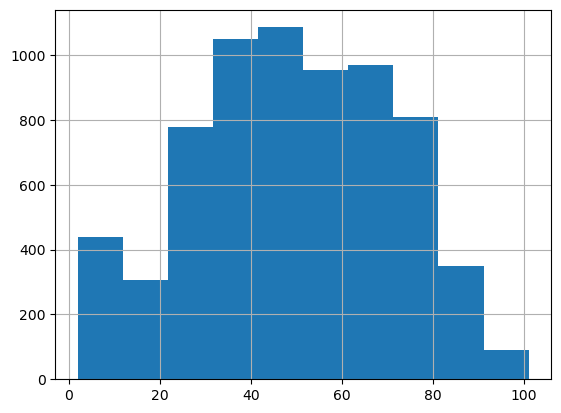

In [28]:
df.age.hist();

#### Sexo

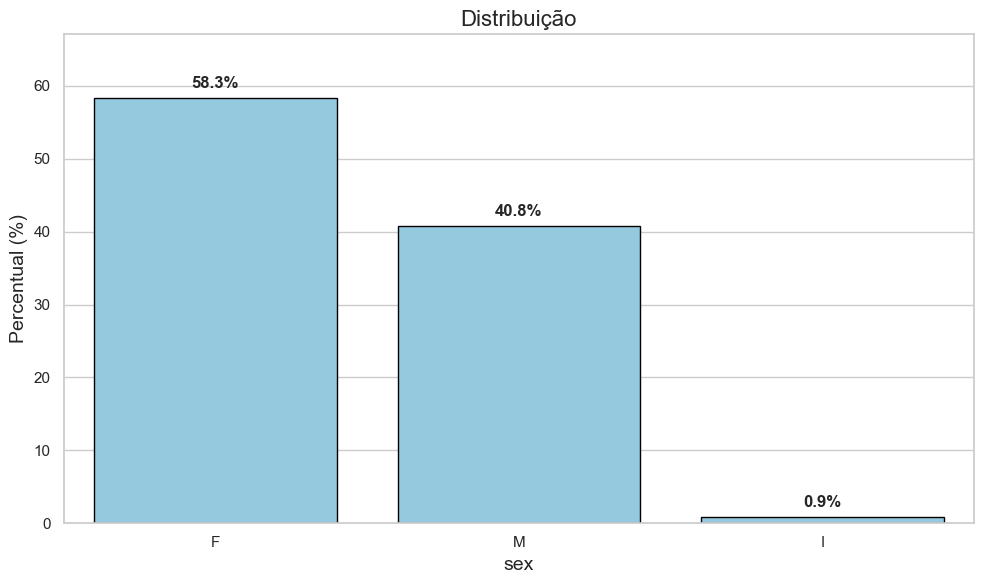

In [30]:
plot_histograma_porcentagem(df,'sex')

In [31]:
df[df.sex == "I"]

,patient_id,age,sex,ehr_date,text
34,16632020,71.0,I,2023-12-08 06:52:04,Os alimentos ricos em colesterol são aqueles d...
212,13374915,25.0,I,2023-09-25 17:16:19,ORIENTAÇÕES PARA QUADRO DE VÔMITOS E/OU DIARRÉ...
344,16703505,68.0,I,2023-06-21 10:30:58,TRIMEBUTINA 200 MG 1 COMP 12/12 H POR 30 DIAS
583,16853500,82.0,I,2023-09-07 09:32:38,ORIENTAÇÕES PARA QUADRO DE VÔMITOS E/OU DIARRÉ...
618,3765571,52.0,I,2023-09-14 07:37:04,"-\tNão utilize açúcar, substitua-o por adoçant..."
720,16515706,24.0,I,2023-08-11 15:11:08,"-\tNão utilize açúcar, substitua-o por adoçant..."
780,4892253,50.0,I,2023-07-06 08:21:19,ORIENTAÇÕES PARA QUADRO DE VÔMITOS E/OU DIARRÉ...
896,3160504,34.0,I,2023-12-20 09:03:21,PACIENTE RELATA AUMENTO DE FERRITINA COM INICI...
910,11766899,61.0,I,2023-07-04 08:56:22,"1. Faça as refeições em ambientes calmos, sem ..."
1134,16192233,28.0,I,2023-11-24 10:58:52,USO ORAL:\r\nISOTRETINOINA ORAL..................


Existe uma gama de pacientes com identificação "I" possivelmente de indeterminado e aparentemente nenhum desse pacientes possuem textos em HTML ou RFT.

#### Frequência de Pacientes

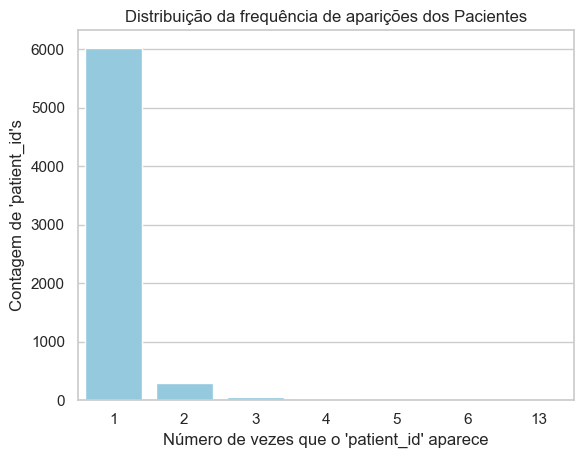

In [34]:
# Contando quantas vezes cada 'patient_id' aparece
patient_counts = df['patient_id'].value_counts()

# Contando quantas vezes ocorre cada contagem
count_of_counts = patient_counts.value_counts().sort_index()

# Criando o gráfico
sns.barplot(x=count_of_counts.index, y=count_of_counts.values, color='skyblue')
plt.xlabel("Número de vezes que o 'patient_id' aparece")
plt.ylabel("Contagem de 'patient_id's")
plt.title("Distribuição da frequência de aparições dos Pacientes")
plt.show()

In [35]:
# Calculando o percentual de cada frequência
total_patients = count_of_counts.sum()
percentages = (count_of_counts / total_patients * 100).round(2)

# Exibindo as porcentagens no formato solicitado
for freq, percent in percentages.items():
    print(f"Frequência {freq}: {percent}%")

Frequência 1: 94.48%
Frequência 2: 4.45%
Frequência 3: 0.77%
Frequência 4: 0.19%
Frequência 5: 0.06%
Frequência 6: 0.03%
Frequência 13: 0.02%


Aproximadamente 94.5% dos pacientes aparece somente 1 vez. Será preciso análises mais aprofundadas de como usar essa informação.

------------

#### Classificando os tipos de Texto

In [39]:
df['text_type'] = df.apply(classifica_texto, axis=1)

In [40]:
df.head()

,patient_id,age,sex,ehr_date,text,text_type
0,341196,82.0,M,2023-09-05 10:23:37,"<html tasy=""html5""><body><p style=""text-align:...",html
1,4309949,32.0,F,2023-11-01 12:10:59,"<html tasy=""html5""><body><p style=""text-align:...",html
2,404932,91.0,M,2023-09-16 07:24:02,{\rtf1\ansi\ansicpg1252{\fonttbl{\f0\fnil\fcha...,rft
3,5603035,53.0,F,2024-08-03 06:56:48,RET 6 MESES PARA AVALIAÇÃO CALCIO + VIT D,texto simples
4,154876,27.0,M,2023-11-05 04:58:01,{\rtf1\ansi\ansicpg1252{\fonttbl{\f0\fnil\fcha...,rft


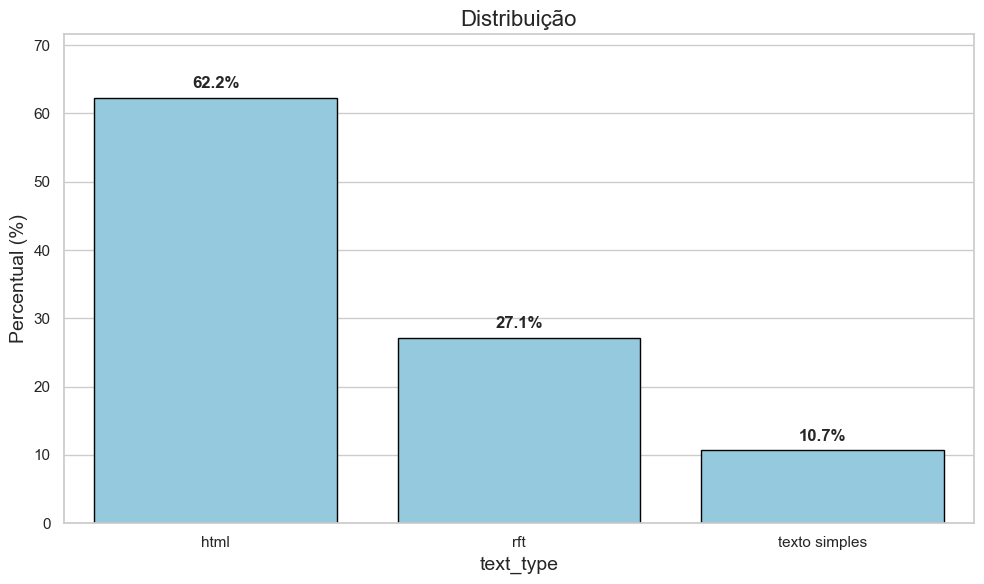

In [41]:
plot_histograma_porcentagem(df, 'text_type')

A maioria dos textos estão em formatação html, uma pequena parte em rft e uma menor em textos simples. Com a presença de RTF e HTML, há muitos caracteres de escape ou formatação (por exemplo, {, \f, \b) que não têm valor semântico e precisam ser removidos para uma análise de conteúdo mais precisa.

------------

### Limpeza dos Dados

In [45]:
df['clean_text'] = df['text'].apply(limpar_texto)

In [46]:
df.head()

,patient_id,age,sex,ehr_date,text,text_type,clean_text
0,341196,82.0,M,2023-09-05 10:23:37,"<html tasy=""html5""><body><p style=""text-align:...",html,anamnese centro clínico queixa principal dor ...
1,4309949,32.0,F,2023-11-01 12:10:59,"<html tasy=""html5""><body><p style=""text-align:...",html,paciente com cefaleia occipital crise há 3 dia...
2,404932,91.0,M,2023-09-16 07:24:02,{\rtf1\ansi\ansicpg1252{\fonttbl{\f0\fnil\fcha...,rft,anotac7c3o de enfermagem 0700 receb...
3,5603035,53.0,F,2024-08-03 06:56:48,RET 6 MESES PARA AVALIAÇÃO CALCIO + VIT D,texto simples,ret 6 meses para avaliação calcio vit d
4,154876,27.0,M,2023-11-05 04:58:01,{\rtf1\ansi\ansicpg1252{\fonttbl{\f0\fnil\fcha...,rft,evoluc7c3o de enfermagem conferido pulseir...


In [47]:
df.clean_text

0       anamnese  centro clínico queixa principal dor ...
1       paciente com cefaleia occipital crise há 3 dia...
2       anotac7c3o de enfermagem           0700  receb...
3                ret 6 meses para avaliação calcio  vit d
4       evoluc7c3o de enfermagem     conferido pulseir...
                              ...                        
6829    anotac7c3o de enfermagem                realiz...
6830    evolue7e3o me9dica           recebo resultado ...
6831    anotação de enfermagem  1800 recebo plantão pa...
6832    nome bruna alves pinto pereira 32 anos dn 1912...
6833    ret com exame nega novos episódios de dor torá...
Name: clean_text, Length: 6834, dtype: object

In [48]:
df.clean_text[2]

'anotac7c3o de enfermagem           0700  recebo plante3o em posto de enfermagem           0730  paciente acomodado no leito com grades e decubitos elevados mantendo avp em mse sem sinais flogedsticos refere dm has e  alergia medicamentosa a  normofloxacinamantendo pulseira de identificae7e3o pulseira roxa para risco de queda e pulseira vermelha para risco de alergia medicamentosa acompanhado da cuidadora e da filha orientadas sempre que necessario solicitar a enfermagem atraves da campanhia realizo aferie7oes ssvv           0800 medicado cpm e adep           0840 ofertado cafe  da tarde com boa aceitae7e3o         0  1000 feito troca de fralda nc3o apresenta evacuae7e3o    0     0  1200 permanece em leito    0     0  1300 passo plante3o segue aso cuidados da equipe    0     0  jaqueline v theodoro    0  estagio    0'

O "ç" e outras letras com acento estão codificados nos textos rft, vamos criar e aplicar uma nova função para corrigir esse problema.

In [50]:
df['clean_text'] = df['clean_text'].apply(corrigir_codificacao)

In [51]:
df.clean_text[2]

'anotação de enfermagem recebo plantão em posto de enfermagem paciente acomodado no leito com grades e decubitos elevados mantendo avp em mse sem sinais flogedsticos refere dm has e alergia medicamentosa a normofloxacinamantendo pulseira de identificação pulseira roxa para risco de queda e pulseira vermelha para risco de alergia medicamentosa acompanhado da cuidadora e da filha orientadas sempre que necessario solicitar a enfermagem atraves da campanhia realizo aferiçoes ssvv medicado cpm e adep ofertado cafe da tarde com boa aceitação feito troca de fralda não apresenta evacuação permanece em leito passo plantão segue aso cuidados da equipe jaqueline v theodoro estagio'

In [52]:
df.clean_text[4]

'evolução de enfermagem conferido pulseira de identificação e risco de queda nega alergias ba dih hipótese diagnóstica j159 pneumonia bacteriana nao especificada pneumonia viral aguarda pcr covid broncoespasmo associado histd3ria clcdnica paciente refere sinais e sintomas gripais com tosse intensa dificuldades para respirar apresenta sudorese e taquipneia aberto protocolo de sepse no psa com paciente evoluindo para dessaturação de e fr refere não fumar ou fazer uso de substancias inalantes interna em uti em mnr e taquipneia para vigilancia respiratoria diagnd3sticos prévios nega alergias nega medicaçd5es de uso prévio especificar dosagem e intervalo nega alergias nega estado geral cliente acomodado no leito com grades e decudito elevados orientado calmo afebril corado sem queixas algicas no momento mantendo pulseira de identificação e risco de queda mantendo avp em mse datado do dia salinizado e sem sinais flogedticos integridade cutânea integra para lpp mantendo colchão pneumático ava

In [53]:
df.clean_text[6828]

'anotação de enfermagem 1100hrs recebo paciente em rampa cirurgica acomodado no leito em ddh com cabeceira grades elevadas e rodas travadas poi de retirada de fixador externo direitoproveniente do centro cirurgico em maca calmo contactuando eupneico em tempo de espaço em aa acompanhada pelo tecnica do transporte mantendo pela integra pulseira de indentificaçaoe risco de queda roxa segue com avp em mse com jelco salinizado e sem sinais flogisticos nega has refere dm e nega alergia medicamentosa sem queixas de algias com curativo gaze pelicula transparente segue aos cuidados da enfermagem e orientado a chamar sempre que necessario1110hrs aferido ssvv1130hrs aguardando almoço1200hrs passo plantão sem nenhuma intercorrencia seguindo apenas de alta após visita do medico cirurgião isabela rayane cagnotto de limaauxilar de enfermagemcoren'

Aparentemente, agora está correto

------------

### Núvem de palavras

Removendo stopwords

In [58]:
df.clean_text

0       anamnese centro clínico queixa principal dor i...
1       paciente com cefaleia occipital crise há dias ...
2       anotação de enfermagem recebo plantão em posto...
3                   ret meses para avaliação calcio vit d
4       evolução de enfermagem conferido pulseira de i...
                              ...                        
6829    anotação de enfermagem realizado medicação seg...
6830    evolução médica recebo resultado de exame urin...
6831    anotação de enfermagem recebo plantão paciente...
6832    nome bruna alves pinto pereira anos dn estado ...
6833    ret com exame nega novos episódios de dor torá...
Name: clean_text, Length: 6834, dtype: object

In [59]:
df.clean_text = df.clean_text.apply(remove_stopwords)

In [60]:
df.clean_text

0       anamnese centro clínico queixa principal dor i...
1       paciente cefaleia occipital crise dias sensaçã...
2       anotação enfermagem recebo plantão posto enfer...
3                        ret meses avaliação calcio vit d
4       evolução enfermagem conferido pulseira identif...
                              ...                        
6829    anotação enfermagem realizado medicação seguin...
6830    evolução médica recebo resultado exame urina l...
6831    anotação enfermagem recebo plantão paciente le...
6832    nome bruna alves pinto pereira anos dn estado ...
6833    ret exame nega novos episódios dor torácica pr...
Name: clean_text, Length: 6834, dtype: object

Vamos analisar a nuvem de palavras geral e depois por tipo de texto para podermos averiguar se elas se tratam de diferentes tipo de procedimentos ou processos dentro do hospital.

#### Geral

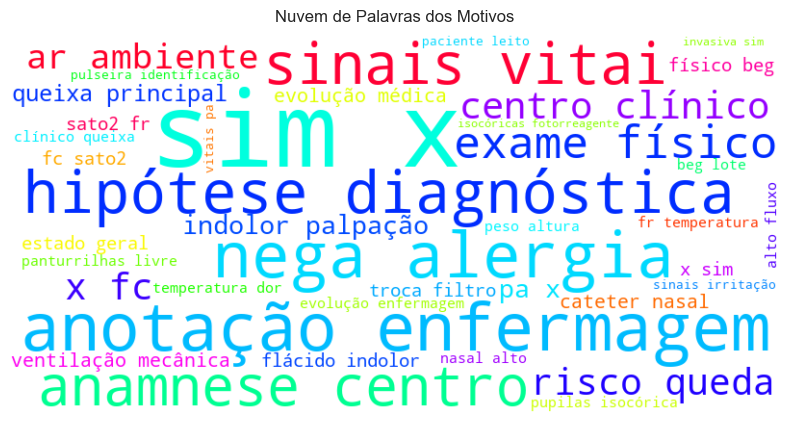

In [113]:
text = ' '.join(df.clean_text)
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      max_words=40, colormap='hsv').generate(text)

# Exibir a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras dos Motivos')
plt.show()

#### Texto HTML

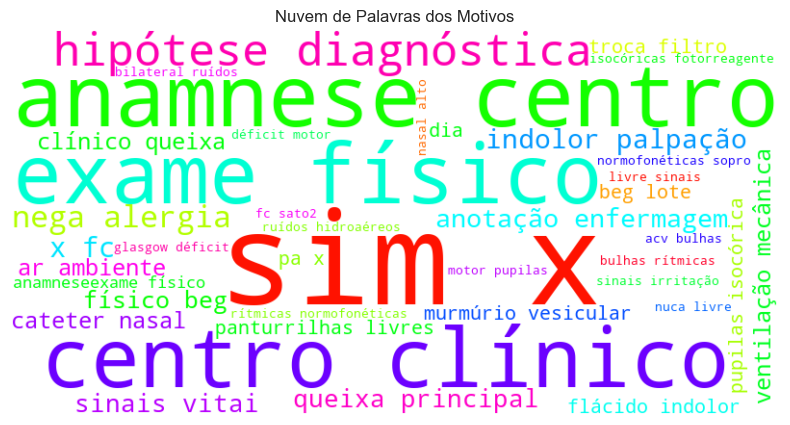

In [111]:
text = ' '.join(df[df.text_type == 'html'].clean_text)
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      max_words=40, colormap='hsv').generate(text)

# Exibir a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras dos Motivos')
plt.show()

#### Texto RFT

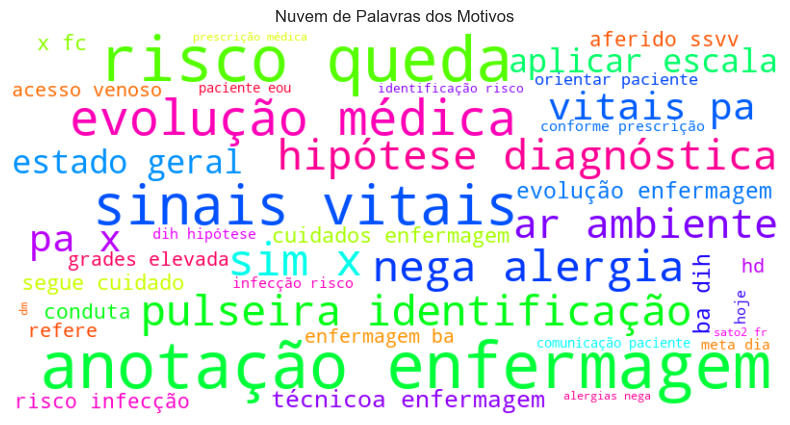

In [116]:
text = ' '.join(df[df.text_type == 'rft'].clean_text)
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      max_words=40, colormap='hsv').generate(text)

# Exibir a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras dos Motivos')
plt.show()

#### Texto Simples

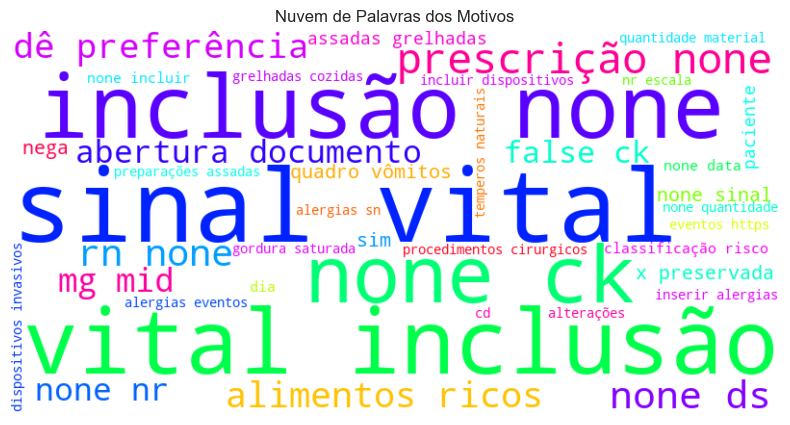

In [121]:
text = ' '.join(df[df.text_type == 'texto simples'].clean_text)
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      max_words=40, colormap='hsv').generate(text)

# Exibir a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras dos Motivos')
plt.show()

In [155]:
# Cria tabelas para cada tipo de texto
tabela_html = contar_palavras_por_tipo(df, 'html', top_n=30)
tabela_rtf = contar_palavras_por_tipo(df, 'rft', top_n=30)
tabela_texto_simples = contar_palavras_por_tipo(df, 'texto simples', top_n=30)

# Exibir os resultados
print("Palavras mais frequentes em HTML:\n", tabela_html)
print("\nPalavras mais frequentes em RTF:\n", tabela_rtf)
print("\nPalavras mais frequentes em Texto Simples:\n", tabela_texto_simples)

Palavras mais frequentes em HTML:
            Palavra  Frequência
29150     paciente        4501
35020       sinais        3399
27043         nega        3284
14631          dor        2044
17101        exame        1748
34966          sim        1620
15639   enfermagem        1597
37929          uso        1570
18878       físico        1462
32898       refere        1362
23526        leito        1288
17139       exames        1267
17067     evolução        1214
13633  diagnóstica        1187
5465      alergias        1176
6170      anamnese        1170
17719           fc        1155
13561          dia        1131
11197      conduta        1064
6972            ar        1045
9711        centro         998
32192       queixa         978
33454      retorno         975
28734      oriento         958
7718     avaliação         957
13828         dias         955
20824     hipótese         942
10427      clínico         942
32609    realizado         921
33949       ruídos         906

Pal

Observando as palavras mais frequentes em cada tipo de texto, podemos levantar algumas hipóteses sobre as finalidades de cada tipo:

**1- HTML:**

<p>As palavras mais frequentes, como "paciente", "sinais", "nega", "dor", "enfermagem" e "diagnóstica", sugerem um foco em documentação clínica. Termos como "exame", "avaliação", "hipótese", "conduta", "alergias" e "realizado" indicam que o texto em HTML pode estar sendo utilizado para registro de observações médicas e diagnósticos.</p>
<p>A presença de termos técnicos e específicos sugere que essa categoria talvez seja voltada para um registro detalhado de status e histórico do paciente, possivelmente com uso em prontuários ou anotações de avaliação médica.</p>

**2- RFT:**

<p>As palavras mais comuns como "paciente", "enfermagem", "risco", "sinais", "queda", "anotação" e "cuidados" indicam que este tipo de texto provavelmente está voltado para anotações de enfermagem.</p>
<p>A frequência de palavras como "pulseira", "orientação", "geral", "conforme", "avaliação" e "vital" sugere que o RTF pode ser utilizado para anotar instruções de cuidados e riscos associados ao paciente.</p>
<p>Esse tipo de texto parece ser destinado a documentos que registram as ações realizadas por enfermeiros, monitorando e atualizando o estado e as medidas de precaução para o paciente.</p>

**3- Texto Simples:**

<p>Com palavras como "none", "false", "ck", "uso", "sim", "nr", "true", "sinal", "vital" e links como "https", parece que esse texto tem elementos técnicos e códigos misturados com informações clínicas, o que sugere que pode estar relacionado a um formato de transferência de dados ou uma plataforma que usa valores booleanos (verdadeiro/falso).</p>
<p>O uso de termos relacionados a alimentos e dieta, como "alimentos", "carnes", "gordura", "dieta", "evitar", indica que ele também pode conter orientações nutricionais ou de dieta do paciente, possivelmente em um contexto onde registros de dieta ou restrições alimentares são relevantes.
A presença de valores booleanos e variáveis também sugere que pode ser uma exportação ou integração com outro sistema, onde esses textos estão em um formato simplificado e talvez voltado para armazenar dados estruturados.</p>